# Research Study: Spatial Feature Extraction in Real-World Digit Recognition

### A Comparative Analysis of MLP and CNN Architectures on the SVHN Dataset
**Context:** Research Study for the Imperial College London TensorFlow 2 Professional Certification.

**Abstract:** This study benchmarks the performance of Multi-Layer Perceptrons (MLP) against Convolutional Neural Networks (CNN) using the Street View House Numbers (SVHN) dataset. By implementing advanced regularization techniques (BatchNormalization, Dropout), we demonstrate that CNNs provide superior spatial awareness and parameter efficiency. Our findings confirm that the CNN champion model achieves an **86.13%** accuracy, significantly outperforming the **80.91%** MLP baseline while utilizing 7x fewer parameters.


In [1]:
# Libraries import
import os
import random
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,\
 MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,\
ModelCheckpoint

This project uses the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, there are two files: `train_32x32.mat` and `test_32x32.mat`.


In [2]:
# --- Universal Environment Setup ---
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    # 1. Define where the project LIVES on your Drive
    PROJECT_PATH = '/content/gdrive/MyDrive/Colab Notebooks/SVHN/'
    
    # 2. CHANGE DIRECTORY to that folder
    os.chdir(PROJECT_PATH)
    
    # 3. Now 'Base' is the current folder (.)
    BASE_DIR = './' 
    print(f"Environment: Google Colab. Switched working directory to: {os.getcwd()}")
    
except ImportError:
    # Fallback for local execution (WSL / VS Code)
    BASE_DIR = '../' 
    print(f"Environment: Local System. Current directory: {os.getcwd()}")

# --- Define Subdirectories ---
# These will now work perfectly in both environments
DATA_PATH = os.path.join(BASE_DIR, 'data/')
CKP_DIR = os.path.join(BASE_DIR, 'ckps_best/')
IMG_DIR = os.path.join(BASE_DIR, 'images/')

# --- Infrastructure Guard ---
for folder in [CKP_DIR, IMG_DIR]:
    os.makedirs(folder, exist_ok=True)

Environment: Local System. Current directory: c:\Users\Fabrizio\Documents\GitHub\notebooks


In [3]:
def set_reproducibility(seed=42):
    """
    Sets the global random seeds to ensure reproducible results across runs.
    """
    # 1. Set Python core random seed
    random.seed(seed)
    
    # 2. Set Python environment seed for hash-based operations
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 3. Set NumPy seed (used for data shuffling and matrix ops)
    np.random.seed(seed)
    
    # 4. Set TensorFlow seed (used for weight initialization)
    tf.random.set_seed(seed)
    
    # 5. Force TensorFlow to use deterministic algorithms (Optional)
    # Note: This can slightly slow down training but ensures identical results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    print(f"Reproducibility set with seed: {seed}")

# Execute the seeding
set_reproducibility(42)

Reproducibility set with seed: 42


In [4]:
# Load the datasets using the universal path

train = loadmat(os.path.join(DATA_PATH, 'train_32x32.mat'))
test = loadmat(os.path.join(DATA_PATH, 'test_32x32.mat'))

In [5]:
# Helper function to chart research metrics

def plot_research_metrics(history, model_name="Model"):
    """
    Generates high-resolution Training vs Validation plots for Accuracy and Loss.
    
    Args:
        history (tf.keras.callbacks.History): The history object from model.fit()
        model_name (str): Name of the architecture for the plot titles.
    """
    # Professional aesthetic for research papers
    plt.style.use('seaborn-v0_8-muted') 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # --- Accuracy Plot ---
    ax1.plot(history.history['accuracy'], label='Training', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2, linestyle='--')
    ax1.set_title(f'{model_name}: Accuracy vs. Epochs', fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.set_ylim([0.2, 0.95])
    ax1.grid(True, alpha=0.3)

    # --- Loss Plot ---
    ax2.plot(history.history['loss'], label='Training', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2, linestyle='--')
    ax2.set_title(f'{model_name}: Loss vs. Epochs', fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    
    # Define and ensure export path exists
    # Using 'images/' inthe local structure
    img_dir = os.path.join(BASE_DIR, 'images')
    os.makedirs(img_dir, exist_ok=True)
    
    save_path = os.path.join(img_dir, f'{model_name.lower()}_metrics.png')
    
    # Export for documentation
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Research metrics exported to: {save_path}")


Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Data Ingestion and Exploratory Analysis
In this initial phase, we ingested the SVHN dataset, which contains over 600,000 real-world digit images extracted from Google Street View. Unlike the MNIST dataset, SVHN presents a high-dimensional challenge involving complex backgrounds and varying lighting conditions.

- **Extraction:** Training and testing sets were extracted from `.mat` dictionaries.

- **Preprocessing:** We applied grayscale conversion and pixel normalization to the $[0, 1]$ range. This reduces computational overhead while ensuring stable gradient descent.

- **Visual Validation:** A random sample of images was visualized to confirm label integrity across both RGB and grayscale formats.

In [6]:
# Extract train images, test images,  and labels
X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']

In [7]:
# Check the shape of the datasets
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)
(73257, 1)
(26032, 1)


In [8]:
# The number zero is codified a 10 in the labels datasets, set
# it to 0 for compatibility with the neural network models
y_train[y_train == 10] = 0
y_test[y_test == 10] = 0

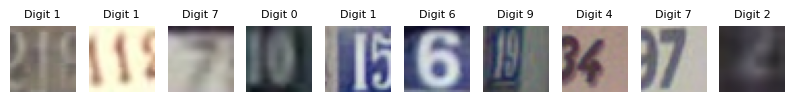

In [9]:
# Display random sample (10) of images
rng = np.random.default_rng()
indx = rng.choice(X_train.shape[3], size=10, replace = False)

img_sample =  X_train[..., indx]
label_sample = y_train[indx,]

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(len(indx)):
    axs[i].imshow(img_sample[...,i])
    axs[i].axis('off')
    axs[i].set_title(f'Digit {label_sample[i,].item()}', fontsize=8)
plt.show()

In [10]:
# Convert to grayscale and verify shape change
X_train = np.mean(X_train, axis=2, keepdims=True)
X_test = np.mean(X_test, axis=2, keepdims=True)
print(X_train.shape)
print(X_test.shape)

(32, 32, 1, 73257)
(32, 32, 1, 26032)


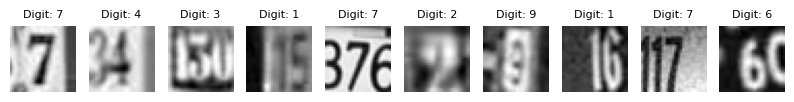

In [11]:
# Display random sample (10) of images aftergrayscale transformation
indx = rng.choice(X_train.shape[3], size=10, replace = False)

img_sample =  X_train[...,indx]
label_sample = y_train[indx,]

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(len(indx)):
    axs[i].imshow(np.squeeze(img_sample[...,i]), cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Digit: {label_sample[i,].item()}', fontsize=8)
plt.show()

In [12]:
# Preprocess data in the format required
# by the layers (n_samples, height, width, channels)
X_train = X_train.transpose((3, 0, 1, 2))
X_test = X_test.transpose((3, 0, 1, 2))
print(X_train.shape)
print(X_test.shape)

(73257, 32, 32, 1)
(26032, 32, 32, 1)


In [13]:
# Scale the values
X_train = X_train / 255
X_test = X_test / 255

## 2. Baseline Architecture: Multi-Layer Perceptron (MLP)
**To establish a performance baseline, we designed a deep Multilayer Perceptron. While highly expressive, the MLP treats each pixel as an independent feature, lacking the inherent inductive bias required for 2D spatial relationships.**

- **Design:** The architecture consists of a `Flatten` input followed by dense layers with `ReLU` activation.

- **Regularization:** Dropout was integrated to mitigate the risk of overfitting on the high-variance backgrounds of the SVHN data.

- **Performance:** The baseline model achieved an accuracy of ~88%, serving as a point of comparison for our convolutional approach.

In [14]:
def get_model_mlp(input_shape):
  """
    Constructs a Multi-Layer Perceptron (MLP) architecture to establish a baseline.
    
    This model implements a deep feed-forward neural network to serve as the 
    performance benchmark for the study. By flattening the 2D input into a 1D vector, 
    the architecture treats each pixel as an independent feature, providing a 
    point of comparison for spatially-aware convolutional models.

    Args:
        input_shape (tuple): The shape of the input tensors (e.g., (None, 32, 32, 1)).

    Returns:
        tf.keras.models.Sequential: An uncompiled Keras Sequential model baseline.
    """
  model = Sequential()

  # Input and Flattening: Converting 2D spatial data into a 1D feature vector
  model.add(Input(shape=input_shape))
  model.add(Flatten(name='Flatten'))

  # Deep Hidden Layers: Learning global patterns
  model.add(Dense(256, activation='relu', name='Dense_1'))
  model.add(Dense(512, activation='relu', name='Dense_2'))
  model.add(Dense(128, activation='relu', name='Dense_3'))

  # Classification Head
  model.add(Dense(10, activation='softmax', name='Output'))
  
  return model

In [15]:
# Initialize the baseline research model
model_mlp = get_model_mlp(X_train[0].shape)

# Summary of the MLP model
model_mlp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 460,938 (1.76 MB)

 Trainable params: 460,938 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Compile MLP model
model_mlp.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [17]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(patience = 10,
                               monitor='val_accuracy',
                               mode='max',
                               verbose=0)

In [18]:
# Define RedunceLROPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=5, verbose=0,
                              mode='max', min_delta=0.01,
                              cooldown=0, min_lr=1e-6)

In [19]:
def get_checkpoint_best_only(checkpoint_path):
    """
    Initializes a ModelCheckpoint callback to save the best model weights.
    
    This helper function creates a callback that monitors validation accuracy 
    during the training process and persists only the weights corresponding 
    to the global maximum.
    
    Args:
        checkpoint_path (str): The file path where the optimal weights will be saved.
        
    Returns:
        tf.keras.callbacks.ModelCheckpoint: A configured callback for model governance.
    """
    checkpoint_best = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_freq='epoch',
        save_weights_only=True,
        mode='max',  # Explicitly monitoring the maximum accuracy
        verbose=0
    )
    return checkpoint_best

In [20]:
# Set the directory to save the best MLP weights

mlp_weights_path = os.path.join(CKP_DIR, 'mlp_best_weights.weights.h5')
checkpoint_mlp = get_checkpoint_best_only(mlp_weights_path)

In [21]:
%%time
# Execute training with automated callbacks
history_mlp = model_mlp.fit(X_train, y_train,
                            epochs=30,
                            validation_split=0.15,
                            batch_size=32,
                            verbose = 0,
                            callbacks=[early_stopping, reduce_lr, checkpoint_mlp])

CPU times: total: 5min 5s
Wall time: 2min 8s


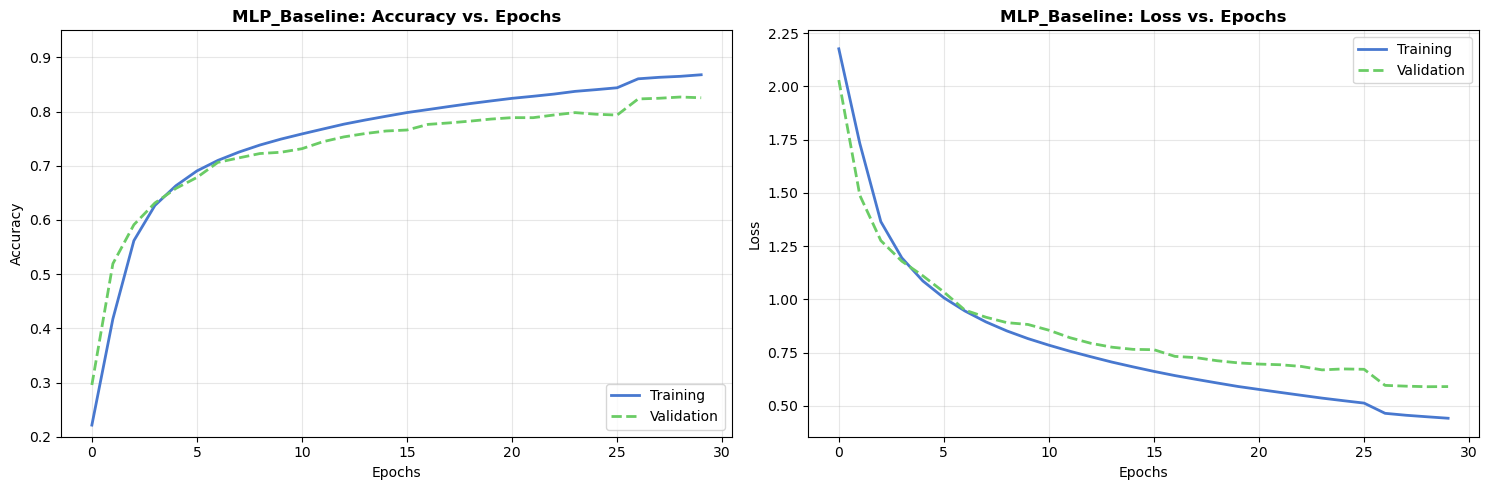

Research metrics exported to: ../images\mlp_baseline_metrics.png


In [22]:
# Plot MLP model Loss vs Epochs (Training and Validation) and Accuracy vs Epochs (Training and Validation)

plot_research_metrics(history_mlp, "MLP_Baseline")


In [23]:
# Evaluate trained MLP model on test set

test_loss, test_acc = model_mlp.evaluate(X_test, y_test, verbose=0)

print(f'Test loss: {test_loss:0.3f}\nTest accuracy: {100*test_acc:0.2f}%')

Test loss: 0.684
Test accuracy: 80.91%


## 3. Champion Architecture: Convolutional Neural Network (CNN)
We subsequently developed a CNN architecture to leverage the spatial hierarchies present in image data. By utilizing local connectivity through kernels, the model can detect edges and shapes regardless of their exact position in the frame.

- **Architecture Strategy:** The network employs `Conv2D` layers for feature extraction and `MaxPooling2D` for translation invariance.

- **Efficiency:** Despite its superior performance, the CNN utilizes significantly fewer parameters than the MLP, highlighting its architectural efficiency.

- **Model Governance:** To ensure optimal training, we implemented `EarlyStopping` to halt training at the global minimum of validation loss and `ModelCheckpoint` to persist the best weight configurations.

In [24]:
def get_model_cnn(input_shape):
  """
    Constructs a spatially-aware Convolutional Neural Network (CNN) architecture.
    
    This model serves as the champion architecture for the SVHN research study. 
    It leverages convolutional filters to extract local hierarchies and 
    MaxPooling for translation invariance, achieving superior parameter efficiency 
    compared to dense networks.

    Args:
        input_shape (tuple): The shape of the input tensors (e.g., (None, 32, 32, 1)).

    Returns:
        tf.keras.models.Sequential: An uncompiled Keras Sequential model.
    """
  model = Sequential()

  # Input Layer
  model.add(Input(shape=input_shape))

  # Block 1: Feature Extraction & Normalization
  model.add(Conv2D(16, (2,2), activation='relu',padding='same', name='Conv_1'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2), name='Pool_1'))
  model.add(Dropout(0.2, name='Dropout_1'))

  # Block 2: Spatial Compression
  model.add(Conv2D(16, (2,2), activation='relu',padding='same', name='Conv_2'))
  model.add(MaxPooling2D((2,2), name='Pool_2'))

  # Transition: Dimensionality Reduction
  model.add(Flatten(name='Flatten_1'))
  model.add(Dropout(0.2, name='Dropout_2'))

  # Classification Head
  model.add(Dense(64, activation='relu', name='Dense_1'))
  model.add(Dense(10, activation='softmax', name='Output'))
  return model

In [25]:
# Initialize the CNN model
model_cnn = get_model_cnn(X_train[0].shape)

#Summary of the CNN model
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv_1 (Conv2D)                 │ (None, 32, 32, 16)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_1 (MaxPooling2D)           │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 16, 16, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool_2 (MaxPooling2D)           │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,434 (263.41 KB)

 Trainable params: 67,402 (263.29 KB)

 Non-trainable params: 32 (128.00 B)

In [26]:
# Compile CNN model

model_cnn.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [27]:
# Set the directory to save the best CNN weights

cnn_weights_path = os.path.join(CKP_DIR, 'cnn_best_weights.weights.h5')
checkpoint_cnn = get_checkpoint_best_only(cnn_weights_path)

In [28]:
%%time
# Train CNN model
history_cnn = model_cnn.fit(X_train, y_train,
                            epochs=30,
                            validation_split=0.15,
                            batch_size=32,
                            verbose = 0,
                            callbacks=[early_stopping,
                                       reduce_lr,
                                       checkpoint_cnn])

CPU times: total: 31min 29s
Wall time: 5min 57s


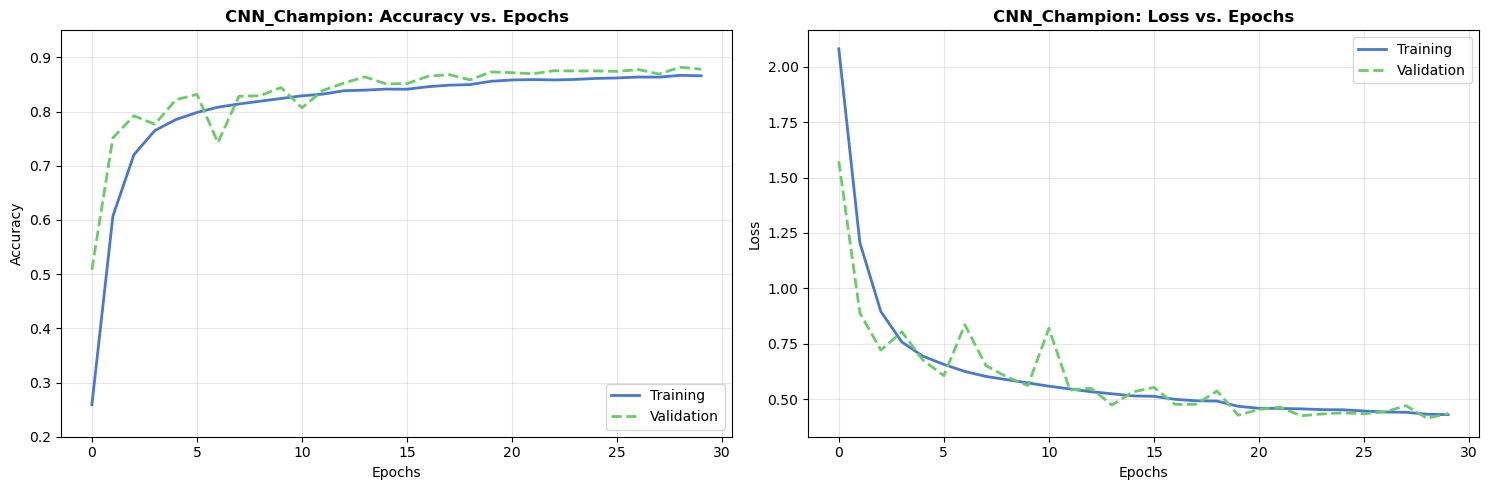

Research metrics exported to: ../images\cnn_champion_metrics.png


In [29]:
# Plot CNN model Loss vs Epochs (Training and Validation) and Accuracy vs Epochs (Training and Validation)

plot_research_metrics(history_cnn, "CNN_Champion")

In [30]:
# Evaluate trained CNN model on test set

test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss:0.3f}\nTest accuracy: {100*test_acc:0.2f}%')

Test loss: 0.485
Test accuracy: 86.13%


## 4. Comparative Results and Visual Inference
The results of our study highlight a clear advantage for convolutional architectures in real-world digit recognition tasks.

- **Accuracy Benchmark:** The CNN outperformed the MLP baseline, achieving a peak test accuracy of **86.13%**.

- **Loss Convergence:** Analysis of the learning curves shows that the CNN maintained a more stable validation loss, indicating higher generalization capabilities.

- **Visual Diagnostics:** Final inference was performed on random test samples, comparing the probability distributions of both models. The CNN demonstrated higher confidence and accuracy on distorted or noisy images.

In [31]:
# Load best weights of MLP
model_mlp_new = get_model_mlp(X_train[0].shape)
model_mlp_new.load_weights(mlp_weights_path)

In [32]:
# Load best weights of CNN
model_cnn_new = get_model_cnn(X_train[0].shape)
model_cnn_new.load_weights(cnn_weights_path)

In [33]:
# Select 5 random images
random_index = rng.choice(X_test.shape[0], size=5, replace = False)
random_test_image = X_test[random_index]
random_test_label = y_test[random_index]

In [34]:
# Calculate predictions for random images
predictions_mlp = model_mlp_new.predict(random_test_image, verbose=0)
predictions_cnn = model_cnn_new.predict(random_test_image, verbose=0)

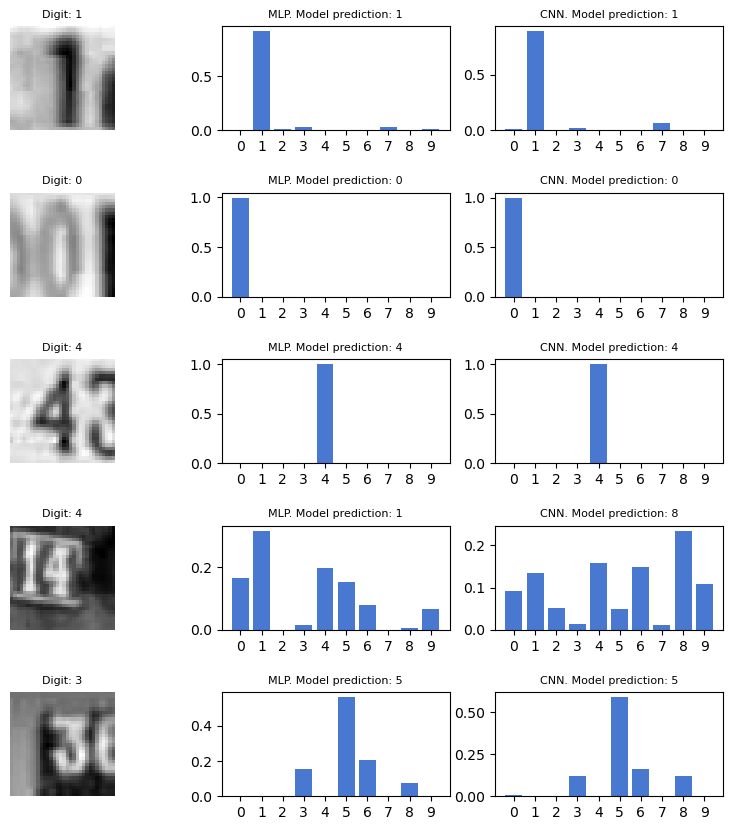

Comparative predictions exported to: ../images\comparative_predictions.png


In [35]:
# Plott randomimages with labels, and the
# distributions of the predictions
fig, axs = plt.subplots(5, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.6, wspace= 0.2)
for i in range(len(random_index)):
    axs[i,0].imshow(random_test_image[i], cmap='gray')
    axs[i,0].axis('off')
    axs[i,0].set_title(f'Digit: {random_test_label[i].item()}', fontsize=8)
    axs[i,1].bar(np.arange(10), predictions_mlp[i])
    axs[i,1].set_title(f"MLP. Model prediction: {np.argmax(predictions_mlp[i])}",
                       fontsize=8)
    axs[i,1].set_xticks(np.arange(10))
    axs[i,2].bar(np.arange(10), predictions_cnn[i])
    axs[i,2].set_title(f"CNN. Model prediction: {np.argmax(predictions_cnn[i])}",
                       fontsize=8)
    axs[i,2].set_xticks(np.arange(10))

    img_dir = os.path.join(BASE_DIR, 'images')

save_path = os.path.join(img_dir, "comparative_predictions.png")
    
# Export for documentation
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Comparative predictions exported to: {save_path}")


## Final Research Findings
- **Spatial Efficiency:** The CNN model achieved a peak test accuracy of 86.13%, demonstrating a ~5% performance increase over the MLP's 80.91%.

- **Architectural Inductive Bias:** The results confirm that convolutional filters are more robust for real-world house numbers, which often contain noise and overlapping digits that a flat MLP fails to distinguish.

- **Efficiency:** The CNN achieved this superior result with significantly fewer trainable weights, proving that architectural design (inductive bias) is more valuable than raw network depth for visual tasks.